In [1]:
from sklearn.preprocessing import StandardScaler as SS
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.cluster import SilhouetteVisualizer

import warnings
warnings.filterwarnings('ignore')

In [2]:
def silhouettePlot(range_, data):
    half_length = int(len(range_)/2)
    range_list = list(range_)
    fig, ax = plt.subplots(half_length, 2, figsize=(15,8))
    for _ in range_:
        kmeans = KMeans(n_clusters=_, random_state=42)
        q, mod = divmod(_ - range_list[0], 2)
        sv = SilhouetteVisualizer(kmeans, colors="yellowbrick", ax=ax[q][mod])
        ax[q][mod].set_title("Silhouette Plot with n={} Cluster".format(_))
        sv.fit(data)
    fig.tight_layout()
    fig.show()

In [3]:
def elbowPlot(range_, data, figsize=(10,10)):
    '''
    the elbow plot function helps to figure out the right amount of clusters for a dataset
    '''
    inertia_list = []
    for n in range_:
        kmeans = KMeans(n_clusters=n, random_state=42)
        kmeans.fit(data)
        inertia_list.append(kmeans.inertia_)
        
    # plotting
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    sns.lineplot(y=inertia_list, x=range_, ax=ax)
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Inertia")
    ax.set_xticks(list(range_))
    fig.show()

In [4]:
def findOptimalEps(n_neighbors, data):
    '''
    function to find optimal eps distance when using DBSCAN; based on this article: https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc
    '''
    neigh = NearestNeighbors(n_neighbors=n_neighbors)
    nbrs = neigh.fit(data)
    distances, indices = nbrs.kneighbors(data)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.plot(distances)

In [5]:
def progressiveFeatureSelection(df, n_clusters=4, max_features=4,):
    '''
    very basic implementation of an algorithm for feature selection (unsupervised clustering); inspired by this post: https://datascience.stackexchange.com/questions/67040/how-to-do-feature-selection-for-clustering-and-implement-it-in-python
    '''
    feature_list = list(df.columns)
    selected_features = list()
    # select starting feature
    initial_feature = ""
    high_score = 0
    for feature in feature_list:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        data_ = df[feature]
        labels = kmeans.fit_predict(data_.to_frame())
        score_ = silhouette_score(data_.to_frame(), labels)
        print("Proposed new feature {} with score {}". format(feature, score_))
        if score_ >= high_score:
            initial_feature = feature
            high_score = score_
    print("The initial feature is {} with a silhouette score of {}.".format(initial_feature, high_score))
    feature_list.remove(initial_feature)
    selected_features.append(initial_feature)
    for _ in range(max_features-1):
        high_score = 0
        selected_feature = ""
        print("Starting selection {}...".format(_))
        for feature in feature_list:
            selection_ = selected_features.copy()
            selection_.append(feature)
            kmeans = KMeans(n_clusters=n_clusters, random_state=42)
            data_ = df[selection_]
            labels = kmeans.fit_predict(data_)
            score_ = silhouette_score(data_, labels)
            print("Proposed new feature {} with score {}". format(feature, score_))
            if score_ > high_score:
                selected_feature = feature
                high_score = score_
        selected_features.append(selected_feature)
        try:
            feature_list.remove(selected_feature)
        except Exception as e:
            print(selected_feature)
            # raise e
        print("Selected new feature {} with score {}". format(selected_feature, high_score))
    return selected_features

In [6]:
full_data = pd.read_csv('full_data.csv')
full_data.shape

(95, 61)

In [169]:
# taken from feat_selec.ipynb

revenue_feats = ['installs', 'orders', 'gmv', 'num_sessions', 'conversion',
       'мужчины моложе трудоспособного возраста',
       'старше трудоспособного возраста', 'Старше 60', 'tour_count',
       'городские женщины старше трудоспо-собного возраста',
       'городские мужчины', 'rich_hotel_feat_rating_std', 'nature_feat',
       'население', 'женщины старше трудоспособного возраста',
       'мужчины моложе трудоспособного возраста.1', 'Возраст от 41 до 50',
       'городские мужчины в трудоспособном возрасте', 'rich_hotel_count',
       'городские мужчины в трудоспособном возрасте.1',
       'Возраст от 51 до 60', 'в трудоспособном возрасте',
       'Возраст от 25 до 30', 'Возраст от 18 до 25', 'городские женщины']

In [170]:
# taken from feat_selec.ipynb

revenue_per_order_feats = ['conversion', 'число турфирм', 'installs',
       'население с доходом ниже границы бедности',
       'tour_feat_rating_std', 'orders', '20тый персентиль дохода',
       'доход от гостиниц/отелей/хостелов в год (тыс)', 'Старше 60',
       'num_sessions', '60тый персентиль дохода',
       'городские женщины старше трудоспо-собного возраста',
       'старше трудоспособного возраста',
       'женщины старше трудоспособного возраста',
       'nature_feat_rating_mean',
       'оценка туристского потока (число ночевок)',
       'оценка туристского потока (число поездок)',
       'мужчины старше трудоспособного возраста', 'gmv', 'средний доход',
       '40ой персентиль дохода', 'tour_count',
       'доля населения с доходом ниже медианы по региону',
       'not_rich_hotel_feat_rating_std', '80тый персентиль дохода']

In [182]:
X = full_data[revenue_per_order_feats].fillna(0)
# X = full_data[revenue_per_order_feats]

In [184]:
scaler = SS()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled = X_scaled.set_index(X.index)

In [185]:
selected_features = progressiveFeatureSelection(X_scaled, max_features=25, n_clusters=4)

Proposed new feature conversion with score 0.5437788416718424
Proposed new feature число турфирм with score 0.5584601310490624
Proposed new feature installs with score 0.5464907503568985
Proposed new feature население с доходом ниже границы бедности with score 0.6027925725303888
Proposed new feature tour_feat_rating_std with score 0.6688358703439757
Proposed new feature orders with score 0.8181677619625938
Proposed new feature 20тый персентиль дохода with score 0.5255314303872668
Proposed new feature доход от гостиниц/отелей/хостелов в год (тыс) with score 0.7067370048623174
Proposed new feature Старше 60 with score 0.597295504507834
Proposed new feature num_sessions with score 0.5470331298793769
Proposed new feature 60тый персентиль дохода with score 0.5346490459476821
Proposed new feature городские женщины старше трудоспо-собного возраста with score 0.600474855533408
Proposed new feature старше трудоспособного возраста with score 0.5985977013032986
Proposed new feature женщины старше

In [186]:
selected_features

['gmv',
 'orders',
 'nature_feat_rating_mean',
 'num_sessions',
 'доход от гостиниц/отелей/хостелов в год (тыс)',
 'installs',
 'tour_feat_rating_std',
 'оценка туристского потока (число ночевок)',
 'оценка туристского потока (число поездок)',
 'число турфирм',
 'городские женщины старше трудоспо-собного возраста',
 'старше трудоспособного возраста',
 'мужчины старше трудоспособного возраста',
 'Старше 60',
 'женщины старше трудоспособного возраста',
 'not_rich_hotel_feat_rating_std',
 'tour_count',
 'средний доход',
 'доля населения с доходом ниже медианы по региону',
 '80тый персентиль дохода',
 '60тый персентиль дохода',
 '40ой персентиль дохода',
 '20тый персентиль дохода',
 'население с доходом ниже границы бедности',
 'conversion']

In [187]:
X_sliced = X_scaled[selected_features]

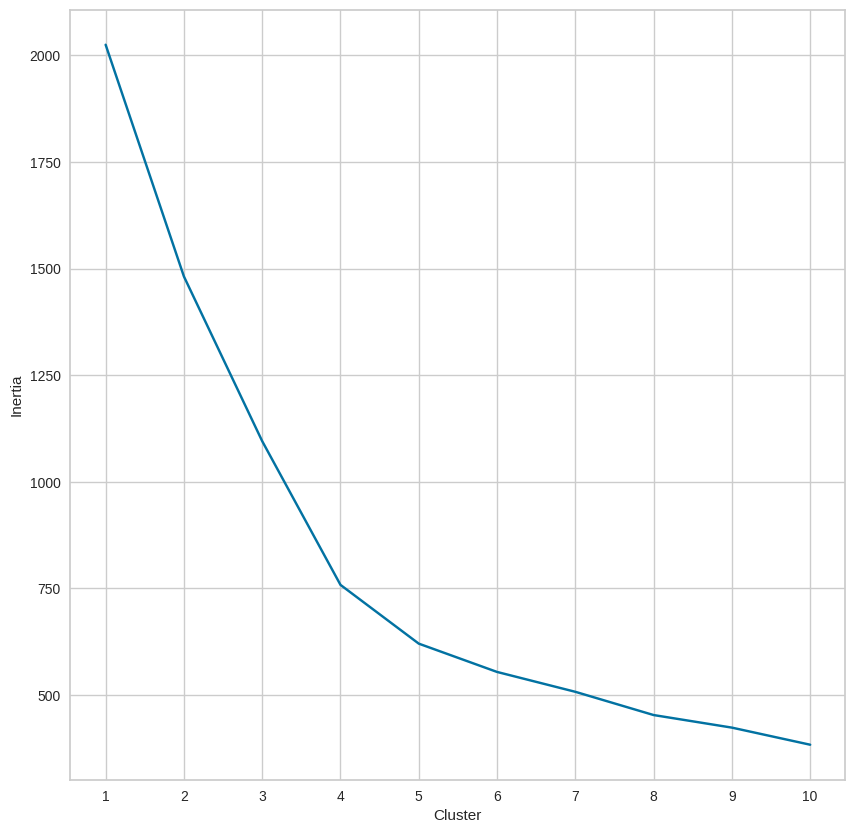

In [188]:
elbowPlot(range(1,11), X_sliced)

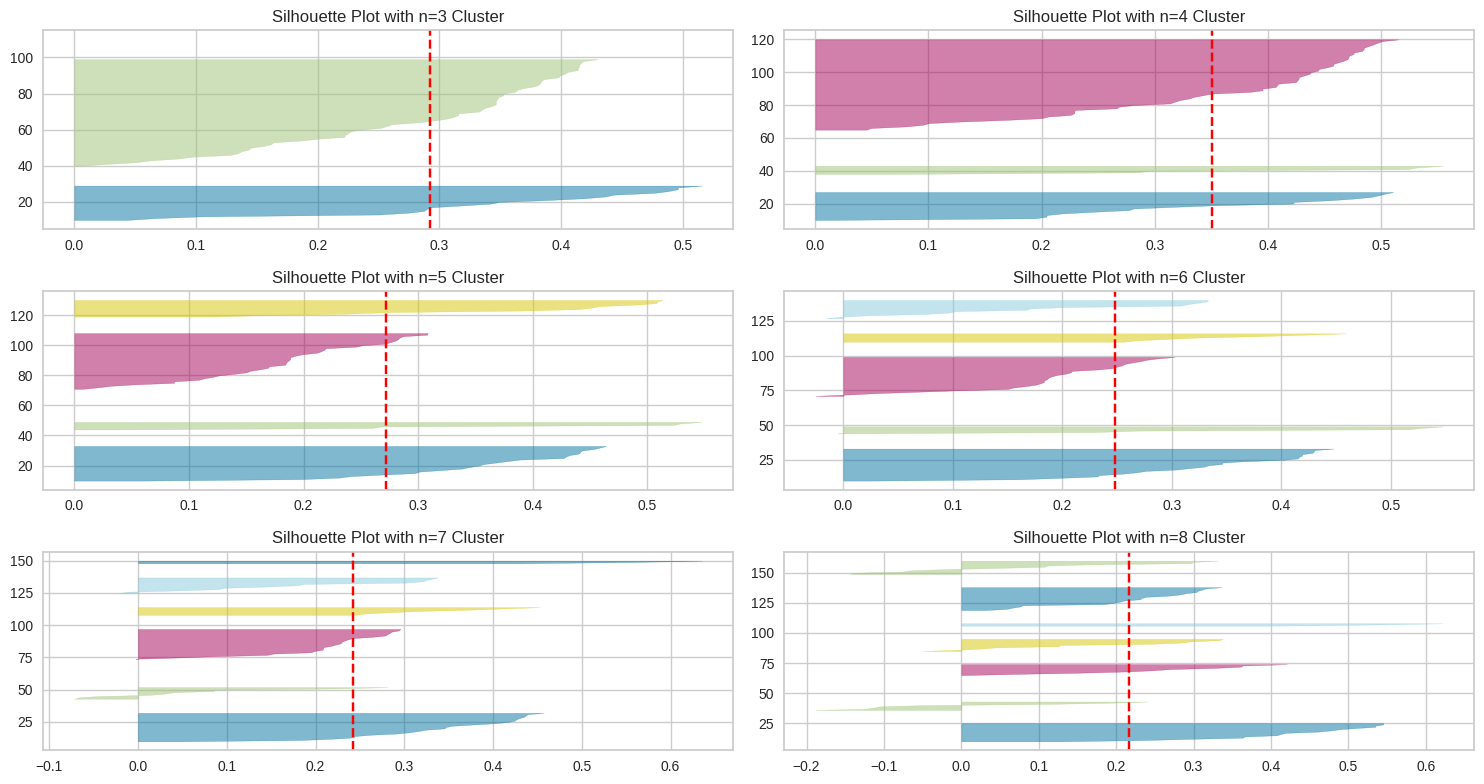

In [189]:
silhouettePlot(range(3,9), X_sliced)

<Axes: xlabel='pc_1', ylabel='pc_2'>

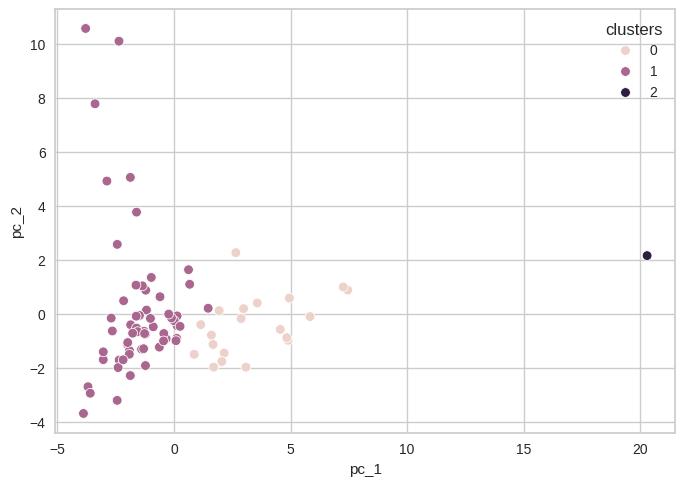

In [190]:
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(X_sliced)
X_sliced["clusters"] = cluster_labels

pca = PCA(n_components=2, whiten=False, random_state=42)
authors_standardized_pca = pca.fit_transform(X_sliced)
df_authors_standardized_pca = pd.DataFrame(data=authors_standardized_pca, columns=["pc_1", "pc_2"])
df_authors_standardized_pca["clusters"] = cluster_labels

sns.scatterplot(x="pc_1", y="pc_2", hue="clusters", data=df_authors_standardized_pca)

In [191]:
full_data['cluster'] = X_sliced["clusters"]

In [195]:
full_data[full_data['cluster'] == 1]

,region,num_sessions,installs,orders,revenue,revenue_quartile,region_russian,revenue_per_order,gmv,conversion,avg_check,cluster
11,Voronezh Oblast,0.217285,0.211892,0.182246,0.192210,Very High,Воронежская область,1.250405,0.035030,0.838745,1.054670,1
18,Saratov Oblast,0.109744,0.166774,0.058696,0.070733,High,Саратовская область,1.600126,0.004152,0.534841,1.205077,1
19,Tyumen Oblast,0.105762,0.088649,0.051087,0.060353,High,Тюменская область,1.590593,0.003083,0.483036,1.181381,1
20,Udmurtiya Republic,0.100612,0.081220,0.052174,0.052417,High,Удмуртская республика,1.349812,0.002735,0.518566,1.004659,1
21,Primorye,0.095889,0.075889,0.073188,0.093338,Very High,Приморский край,1.656426,0.006831,0.763258,1.275312,1
24,Altai Krai,0.091838,0.095934,0.044420,0.049166,High,Алтайский край,1.511222,0.002184,0.483682,1.106844,1
25,Lipetsk Oblast,0.087058,0.080939,0.058623,0.063506,High,Липецкая область,1.438584,0.003723,0.673383,1.083283,1
26,Omsk Oblast,0.085640,0.077434,0.033043,0.041579,High,Омская область,1.769629,0.001374,0.385840,1.258319,1
28,Crimea,0.077716,0.096318,0.071667,0.069936,High,Республика Крым,1.270133,0.005012,0.922159,0.975845,1
29,Leningrad Oblast,0.070457,0.062843,0.048478,0.055295,High,Ленинградская область,1.543784,0.002681,0.688059,1.140621,1
